In [1]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

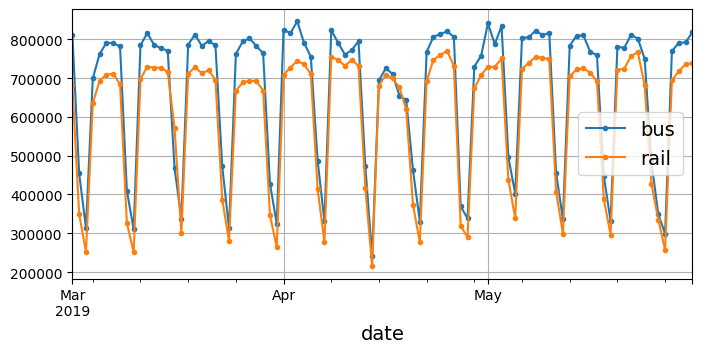

In [5]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
#save_fig("daily_ridership_plot")
plt.show()

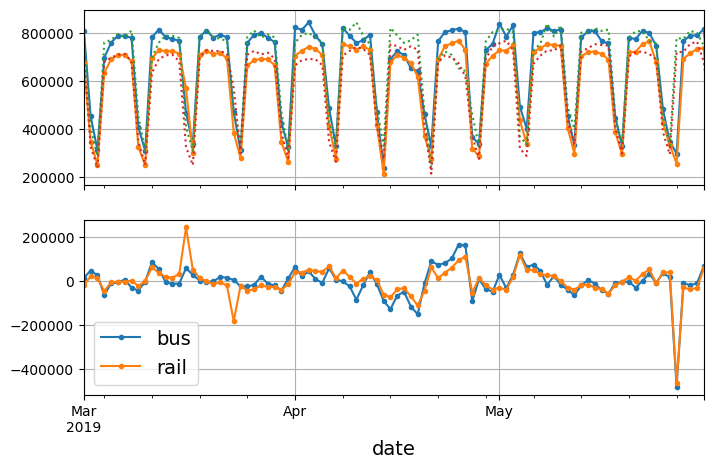

In [6]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
#save_fig("differencing_plot")  # extra code – saves the figure for the book
plt.show()

Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [7]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Mean absolute percentage error (MAPE):

In [8]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

Now let's look at the yearly seasonality and the long-term trends:

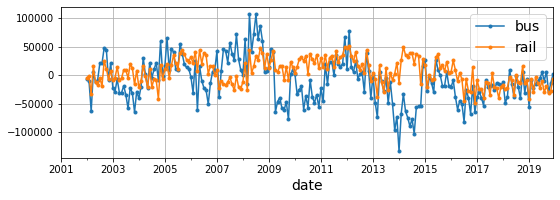

In [ ]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
#save_fig("yearly_diff_plot")  # extra code – saves the figure for the book
plt.show()

If running on Colab or Kaggle, install the statsmodels library:

In [11]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [12]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [17]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [15]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

## Deep RNNs

In [13]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [18]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 9s 139ms/step - loss: 0.0137 - mae: 0.1273 - val_loss: 0.0035 - val_mae: 0.0585
Epoch 2/500
33/33 [==============================] - 5s 136ms/step - loss: 0.0053 - mae: 0.0740 - val_loss: 0.0025 - val_mae: 0.0447
Epoch 3/500
33/33 [==============================] - 6s 174ms/step - loss: 0.0040 - mae: 0.0593 - val_loss: 0.0022 - val_mae: 0.0387
Epoch 4/500
33/33 [==============================] - 4s 125ms/step - loss: 0.0038 - mae: 0.0574 - val_loss: 0.0028 - val_mae: 0.0514
Epoch 5/500
33/33 [==============================] - 6s 185ms/step - loss: 0.0037 - mae: 0.0559 - val_loss: 0.0023 - val_mae: 0.0417
Epoch 6/500
33/33 [==============================] - 4s 125ms/step - loss: 0.0037 - mae: 0.0549 - val_loss: 0.0019 - val_mae: 0.0342
Epoch 7/500
33/33 [==============================] - 6s 178ms/step - loss: 0.0035 - mae: 0.0530 - val_loss: 0.0027 - val_mae: 0.0478
Epoch 8/500
33/33 [==============================] - 4s 126ms/step - 

32057.35981464386

In [19]:
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = deep_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 33ms/step


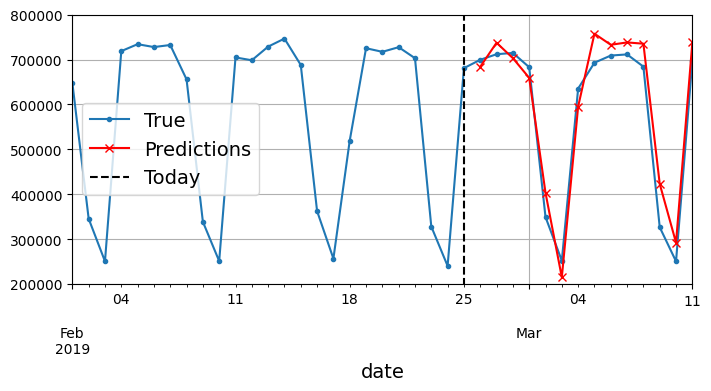

In [21]:
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()